This notebook demonstartes how to use model for Sentinel-2 image matching.<br>
It loads the trained model, evaluates performance on a test dataset and shows some visualisation.

First of all you need to install next libraries if they haven't been installed yet:<br>
torch, torchvision, numpy, matplotlib, cv2, rasterio, pathlib, scipy<br>
You can do it by running next command in console: <i>pip install torch, torchvision, numpy, matplotlib, opencv-python, rasterio, pathlib, scipy</i>

In [52]:
# Importing necessary libraries and classes from model_training.py file
import torch
import cv2
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from pathlib import Path
from torch.utils.data import DataLoader
from rasterio.windows import Window
from model_training import SiameseArrayDataset, EmbeddingNet, ContrastiveLoss, SiameseNet
from scipy.spatial.distance import cdist

Setting device (GPU if possible for faster evaluation) and loading our model. Also setting our loss function

In [53]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SiameseNet(EmbeddingNet()).to(device)
model.load_state_dict(torch.load("best_siamese_model.pth"))
criterion = ContrastiveLoss(margin=1.0)

Loading and preparing our test data

In [54]:
test_data = np.load("pairs_test_data.npz", allow_pickle=True)

test_pairs = test_data["pairs"]
test_labels = test_data["labels"]

test_dataset = SiameseArrayDataset(test_pairs, test_labels)

# We will be giving pairs of images by batches for testing
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Evaluating test loss

In [55]:
model.eval() # Transfer our model into evaluating mode
test_loss = 0.0
TP = 0
TN = 0
FP = 0
FN = 0
total = 0

with torch.no_grad():
    for img1, img2, labels in test_loader:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        out1, out2 = model(img1, img2) # Getting embedding vectors of images from CNN

        euclidean_distance = F.pairwise_distance(out1, out2) # Calculating euclidean distance between embeddings
        predictions = (euclidean_distance < 0.5).float()  # Threshold to define 'same'. We setted it as 0.5
        TP += ((predictions == labels) & (labels == 1)).sum().item()
        TN += ((predictions == labels) & (labels == 0)).sum().item()
        FP += ((predictions != labels) & (labels == 0)).sum().item()
        FN += ((predictions != labels) & (labels == 1)).sum().item()
        total += labels.size(0) # Calculating number of total predictions

        loss = criterion(out1, out2, labels) # Calculating loss function
        test_loss += loss.item()

    avg_loss = test_loss / len(test_loader)

print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0813


Evaluating more test metrics

In [56]:
accuracy = (TP + TN) / total
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f_score = 2 * precision * recall / (precision + recall)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F-score: {f_score:.4f}")

Accuracy: 0.9966
Precision: 1.0000
Recall: 0.9913
F-score: 0.9956


This function finds paths of images by their tile_id and date

In [57]:
def find_band_files(base_dir, tile_id, date_str):
    """
    Returns dict of {band_name: path} for given tile_id and date (YYYYMMDD).
    """
    base_path = Path(base_dir)
    band_paths = {}
    for jp2 in base_path.rglob(f"T{tile_id}_{date_str}*_B*.jp2"):
        # jp2.name like T36UYA_20160212T084052_B04.jp2
        band_name = jp2.stem.split("_")[-1]  # 'B04'
        band_paths[band_name] = jp2
    return band_paths

This function is loading crop from image. Will be used for visualisation

In [58]:
def load_rgb_crop(base_dir, tile_id, date_str, minx, maxx, miny, maxy, size=32):
    """
    Loads a 32x32 RGB crop (B04, B03, B02) from Sentinel-2 data.
    The crop is centered in the given bounding box (map coordinates).
    """
    # Find band file paths
    bands = find_band_files(base_dir, tile_id, date_str)
    
    # Get center coordinates of bbox
    center_x = (minx + maxx) / 2
    center_y = (miny + maxy) / 2
    
    rgb_bands = []
    
    for band_name in ["B04", "B03", "B02"]:  # R, G, B
        path = bands[band_name]
        with rasterio.open(path) as src:
            width, height = src.width, src.height
            col, row = src.index(center_x, center_y)
            half = size // 2
            
            # Compute window boundaries (clip to image size)
            col_start = max(col - half, 0)
            row_start = max(row - half, 0)
            col_end = min(col + half, width)
            row_end = min(row + half, height)
            
            if col_end < col_start:
                col_start, col_end = col_end, col_start
            if row_end < row_start:
                row_start, row_end = row_end, row_start

            w = col_end - col_start
            h = row_end - row_start

            if w <= 0 or h <= 0:
                continue

            window = Window(col_start, row_start, w, h)
            
            # Read one band crop
            patch = src.read(1, window=window)

            valid_pixels = np.count_nonzero(patch)
            if valid_pixels < 1000:
                return None 

            # Pad if at edge
            if patch.shape[0] < size or patch.shape[1] < size:
                pad_h = size - patch.shape[0]
                pad_w = size - patch.shape[1]
                patch = np.pad(patch, ((0, pad_h), (0, pad_w)), mode="reflect")
            
            rgb_bands.append(patch)
    
    # Stack bands → (3, size, size)
    rgb = np.stack(rgb_bands, axis=0).astype(np.float32)
    
    return rgb

This function transforms image into format more appropriate for cv2 library

In [59]:
def preprocess_img(img):
    img = np.transpose(img, (1, 2, 0))  # (H, W, C)
    # If your image is float with arbitrary range, normalize to [0,255]
    img_min, img_max = img.min(), img.max()
    if img_max - img_min > 1e-5:
        img = (img - img_min) / (img_max - img_min)  # normalize to 0..1
    else:
        img = np.zeros_like(img)
    img = (img * 255).astype(np.uint8)
    return img


Loading images of the same location in different times and looking for matches

In [60]:
def extract_patches(img, keypoints, patch_size=32):
    patches = []
    h, w = img.shape[:2]
    half = patch_size // 2

    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        # Extract patch centered at keypoint, with boundary checks
        x1 = max(x - half, 0)
        y1 = max(y - half, 0)
        x2 = min(x + half, w)
        y2 = min(y + half, h)
        
        patch = img[y1:y2, x1:x2]
        
        # If patch smaller than expected (near borders), pad it
        if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
            patch = cv2.copyMakeBorder(
                patch,
                top=0,
                bottom=patch_size - patch.shape[0],
                left=0,
                right=patch_size - patch.shape[1],
                borderType=cv2.BORDER_CONSTANT,
                value=0
            )
        patches.append(patch)

    return patches  # list of 32x32x3 patches

In [61]:
def preprocess_patch(patch):
    # Convert from HWC (height, width, channels) to CHW (channels, height, width)
    patch = np.transpose(patch, (2, 0, 1))  # (3, 32, 32)

    # Convert uint8 [0-255] to float32 [0,1]
    patch = patch.astype(np.float32) / 255.0

    return patch

def preprocess_and_batch(patches):
    processed = [preprocess_patch(p) for p in patches]
    batch_np = np.stack(processed, axis=0)  # shape: (N, 3, 32, 32)
    batch_tensor = torch.from_numpy(batch_np)  # Convert to torch tensor
    return batch_tensor

Function that builds small patches around keypoints

In [62]:
# Getting two images of the same location in different times then transforming them for appropriate format for cv2 library
img1 = load_rgb_crop("full_dataset", "36UXA", "20180820", 604000, 624000, 5530000, 5550000, size = 2048)
img2 = load_rgb_crop("full_dataset", "36UXA", "20190427", 604000, 624000, 5530000, 5550000, size = 2048)
img1_cv = preprocess_img(img1)
img2_cv = preprocess_img(img2)

# Ensure reproducibility
cv2.setRNGSeed(50)

# Finding keypoints and descriptors with ORB
orb = cv2.ORB_create(nfeatures=100)  

kp1, des1 = orb.detectAndCompute(img1_cv, None)
kp2, des2 = orb.detectAndCompute(img2_cv, None)


Match keypoints

In [63]:
patches1 = extract_patches(img1_cv, kp1, patch_size=32)
patches2 = extract_patches(img2_cv, kp2, patch_size=32)

patches1_tensor = preprocess_and_batch(patches1) 
patches2_tensor = preprocess_and_batch(patches2)

with torch.no_grad():
    patches1_tensor, patches2_tensor = patches1_tensor.to(device), patches2_tensor.to(device)
    desc1, desc2 = model(patches1_tensor, patches2_tensor)

This function match descriptors between two sets using nearest neighbors. It is sorting result so best matches are first

In [64]:
def match_descriptors(desc1, desc2, distance_metric='euclidean', ratio_test=0.75):
    """
    Match descriptors between two sets using nearest neighbors and optional ratio test.
    """
    # Compute pairwise distances
    dist_matrix = cdist(desc1, desc2, metric=distance_metric)

    matches = []
    for i in range(dist_matrix.shape[0]):
        # Sort distances for descriptor i to all desc2
        sorted_indices = np.argsort(dist_matrix[i])
        best_idx = sorted_indices[0]
        best_dist = dist_matrix[i, best_idx]

        if ratio_test is not None and len(sorted_indices) > 1:
            second_best_dist = dist_matrix[i, sorted_indices[1]]
            if best_dist > ratio_test * second_best_dist:
                # Reject match due to ratio test
                continue
        
        match = {'queryIdx': i, 'trainIdx': best_idx, 'distance': best_dist}
        matches.append(match)

    # Sort matches by distance (best matches first)
    matches = sorted(matches, key=lambda x: x['distance'])
    return matches

This function convert a list of dictionary-based matches into cv2.DMatch objects

In [65]:
def convert_to_cv2_matches(matches):
    """
    Convert a list of dictionary-based matches into cv2.DMatch objects.
    """
    cv_matches = []
    for m in matches:
        cv_match = cv2.DMatch(
            _queryIdx=int(m['queryIdx']),
            _trainIdx=int(m['trainIdx']),
            _imgIdx=0,
            _distance=float(m['distance'])
        )
        cv_matches.append(cv_match)
    return cv_matches

In [ ]:
matches = match_descriptors(desc1.cpu().numpy(), desc2.cpu().numpy())

# Convert matches to cv2.DMatch and draw
matches_cv = convert_to_cv2_matches(matches)
img_matches = cv2.drawMatches(img1_cv, kp1, img2_cv, kp2, matches_cv[:50], None)

Visualising matches with matplotlib library

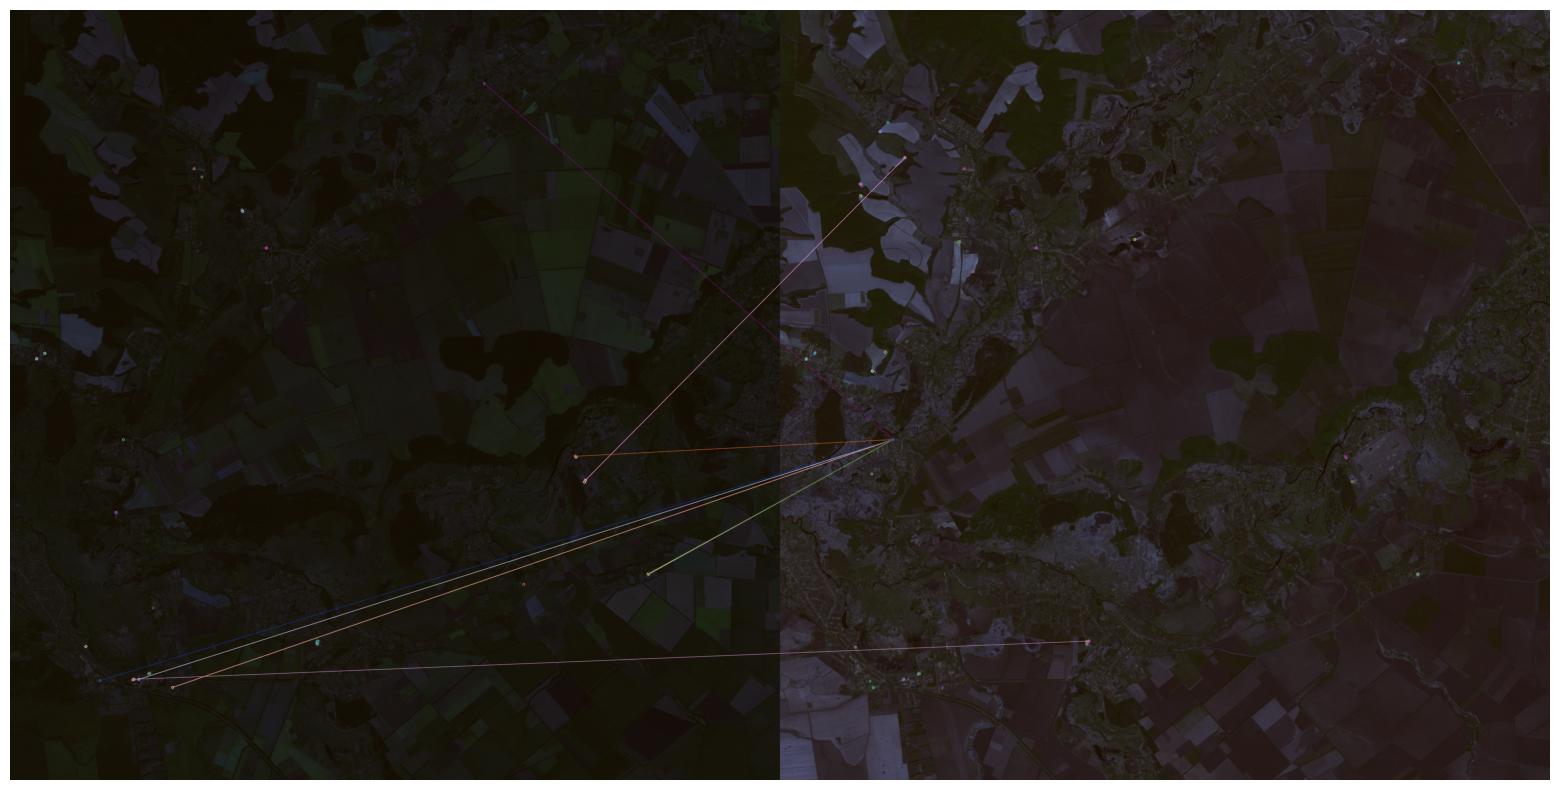

In [67]:
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()